# Orders - Multivariate Regression of  the `review_score`

Let's recall the simple analysis of the Orders: 

Based on the correlation matrix down below, we can notice that `review_score` is mostly correlated to two features: `wait_time` and `delay_vs_expected`.  
However, these two features are also highly correlated to each other.  
  
In this notebook, I will use `statsmodels` to distinguish the effect of one feature, **while holding the other features constant**.

## Import modules

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
root_path = os.path.join(os.getcwd(),'..')
if root_path not in sys.path:
    sys.path.append(root_path)

from utils.order import Order

order_instance = Order()
orders = order_instance.get_training_data(with_distance_seller_customer=True)

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Features')

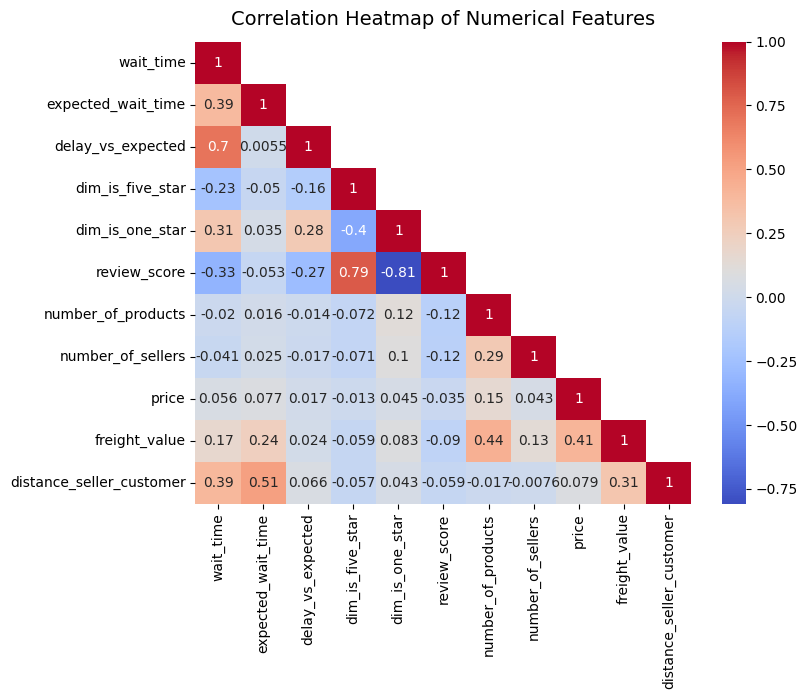

In [3]:
correlation_matrix = orders.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={"size": 10}, mask=mask)
heatmap.set_title('Correlation Heatmap of Numerical Features', fontdict={'fontsize': 14}, pad=12)

## 1. Univariate regression

❓**Using [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html) with `statsmodels.formula.api` to quickly initialize**
 - `model1`: an ols regression of `review_score` over `wait_time`
 - `model2`: an ols regression of `review_score` over `delay_vs_expected`

### Model 1:

In [4]:
model1 = smf.ols('review_score ~ wait_time', data=orders).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.204e+04
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:44:22   Log-Likelihood:            -1.5441e+05
No. Observations:               95872   AIC:                         3.088e+05
Df Residuals:                   95870   BIC:                         3.089e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7236      0.006    727.904      0.0

### Model 2:

In [5]:
model2 = smf.ols('review_score ~ delay_vs_expected', data=orders).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7681.
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:44:22   Log-Likelihood:            -1.5639e+05
No. Observations:               95872   AIC:                         3.128e+05
Df Residuals:                   95870   BIC:                         3.128e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2121      0.00

### Interpretation

Both models have low **R-squared values**, indicating that the predictors **explain a relatively small proportion** of the variance in the dependent variable.  
The t-statistics for the **coefficients are highly significant**, suggesting that both predictors have a **statistically significant impact** on the `review score`.

## 2. Multivariate regression

❓ **What is the impact on `review_score` of adding one day of `delay_vs_expected` to the order, **holding `wait_time` constant**? Which of the two features is the most explicative for the low `review_score`?**

For that purpose, I will run an OLS model `model3` where both `wait_time` and `delay_vs_expected` are the features (independent variables), and `review_score` is the target (dependent variable).

### Model 3:

In [6]:
model3 = smf.ols('review_score ~ wait_time + delay_vs_expected', data=orders).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6191.
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:44:23   Log-Likelihood:            -1.5426e+05
No. Observations:               95872   AIC:                         3.085e+05
Df Residuals:                   95869   BIC:                         3.086e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6502      0.00

### Interpretation

- Holding `wait_time` constant, each additional day of `delay` reduces the review_score on average by 0.0205 [0.023 - 0.018] points
- Holding `delay` constant, each additional day of `wait_time` reduces the review_score on average by 0.0383 [0.039 - 0.037] points

Contrary to what was found with the simple bivariate correlation analysis, `delay` is actually less impactful than `wait_time` in driving lower `review_score`!  
This interesting finding demonstrates the importance of multi-variate regression to remove the potential impact of confounding factors.  

---
❓ **Let's try to add more features to our regression to improve the explainability of the linear regression.**

Creating a new OLS `model4` with more features from the `orders` dataset.
- ⚠️ Avoid **data leaks**: not adding features that are directly derived from the `review_score`
- ⚠️ Avoid adding two features perfectly collinear with each other
- Transforming each feature $X_i$ into its respective z-score $Z_i = \frac{X_i - \mu_i}{\sigma_i}$ in order to compare the partial regression coefficients $\beta_i$ together.  
  Otherwise, the $\beta_i$ won't be in the same dimension, meaning I'll be comparing apples (e.g. `review_stars per day`) with oranges (e.g. `review_stars per BRL`)!

**Note:**  
A **`Multivariate Linear Regression`** is also called an **`Ordinary Least Squares`** method because in this model, we want to minimise the **`MSE Mean Squared Errors`**

### Model 4:

In [7]:
features = [
    "wait_time",
    "delay_vs_expected",
    "number_of_products",
    "number_of_sellers",
    "price",
    "freight_value",
    "distance_seller_customer",
]

In [8]:
# Standardizing the features
orders_standardized = orders.copy()
for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)
orders_standardized

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,-0.431192,15.544063,-0.161781,delivered,0,0,4,-0.264595,-0.112544,-0.513802,-0.652038,-0.979475
1,53cdb2fc8bc7dce0b6741e2150273451,0.134174,19.137766,-0.161781,delivered,0,0,4,-0.264595,-0.112544,-0.086640,0.000467,0.429743
2,47770eb9100c2d0c44946d9cf07ec65d,-0.329907,26.639711,-0.161781,delivered,1,0,5,-0.264595,-0.112544,0.111748,-0.164053,-0.145495
3,949d5b44dbf5de918fe9c16f97b45f8a,0.073540,26.188819,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.441525,0.206815,2.054621
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.019535,12.112049,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.562388,-0.652038,-0.959115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95875,9c5dedf39a927c1b2549525ed64a053c,-0.454309,18.587442,-0.161781,delivered,1,0,5,-0.264595,-0.112544,-0.311513,-0.449408,-0.893033
95876,63943bddc261676b46f01ca7ac2f7bd8,1.023841,23.459051,-0.161781,delivered,0,0,4,-0.264595,-0.112544,0.183977,-0.123156,-0.212797
95877,83c1379a015df1e13d02aae0204711ab,1.305780,30.384225,-0.161781,delivered,1,0,5,-0.264595,-0.112544,0.333684,1.964490,0.617630
95878,11c177c8e97725db2631073c19f07b62,0.483664,37.105243,-0.161781,delivered,0,0,2,1.601605,-0.112544,1.075186,2.715522,-0.387558


In [10]:
formula = "review_score ~ " + ' + '.join(features)
formula

'review_score ~ wait_time + delay_vs_expected + number_of_products + number_of_sellers + price + freight_value + distance_seller_customer'

In [11]:
model4 = smf.ols(formula = formula, data = orders_standardized).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     2322.
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:48:49   Log-Likelihood:            -1.5258e+05
No. Observations:               95872   AIC:                         3.052e+05
Df Residuals:                   95864   BIC:                         3.052e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Interpretation

❓ **What are the most important features?**
- How has the overall regression performance changed?
- Is this regression statistically significant?

<AxesSubplot:>

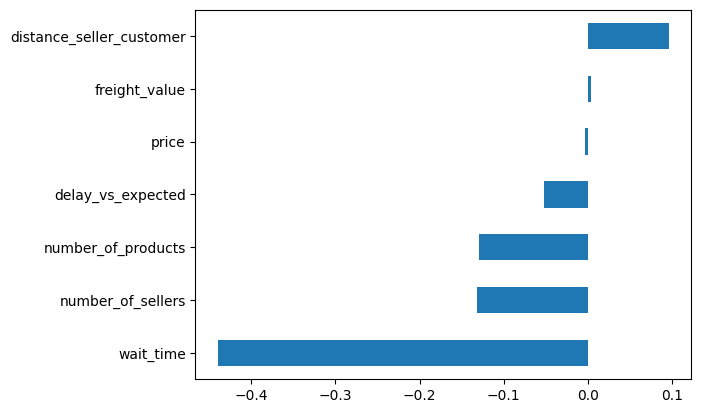

In [12]:
model4.params[1:].sort_values().plot(kind='barh')

- `wait_time` is the biggest explanatory variable
- The more `products` and `sellers` there are for a single order, the lower the `review_score` seems to be
- Distance also plays a role in customers' satisfaction.    
- Overall, this multivariate regression remains statistically significant, because its F-statistics are much greater than 1 (at least one feature has a very low p-value)
- R-squared hasn't increased by much. Most of the explainability of `review_score` lies outside of the orders dataset.

## 3. Check model performance

⚠️ Regression performance should not be measured only by its R-squared!  

❓ **Computing the residuals as well as visualizing the distribution of the predictions, and especially the residuals.**

In [13]:
predicted_review_score = model4.predict(orders_standardized[features])
residuals = predicted_review_score - orders_standardized.review_score

In [14]:
# Computing the associated RMSE
rmse = (residuals**2).mean()**0.5
rmse

1.1883154116821097

(0.0, 5.9397712237118)

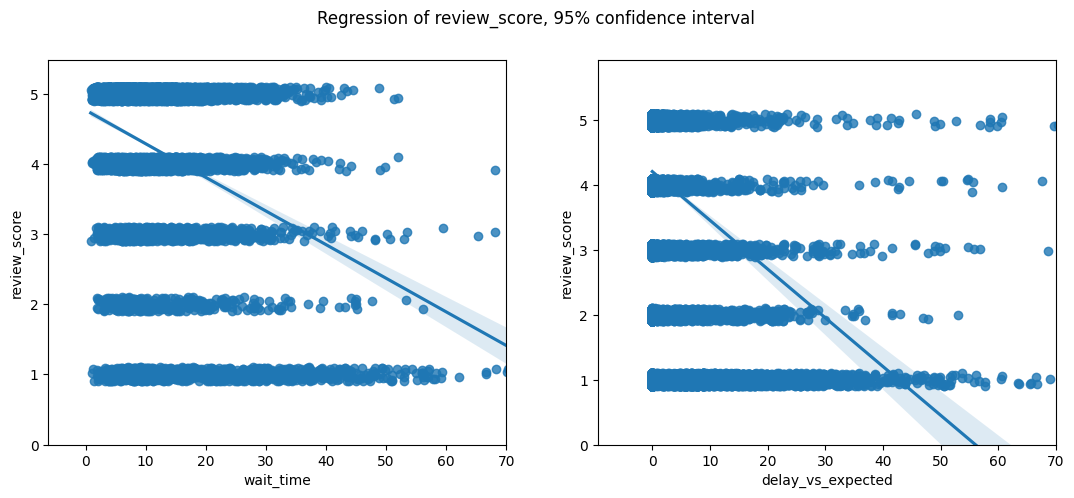

In [15]:
sample = orders.sample(10000, random_state=42)
plt.figure(figsize=(13,5))
plt.suptitle('Regression of review_score, 95% confidence interval')
plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = orders.delay_vs_expected, y= orders.review_score, y_jitter=.1, ci=95)
plt.xlim(right=70)
plt.ylim(bottom=0)

I can see that it is hard to regress the `review_score` of an order vs. its `wait_time`.  
Because the `review_score` is a discrete number that could also be interpreted as a category: 1 (very bad), 2 (bad), 3 (average), 4 (good), 5 (excellent).

☝️ So in the end, my model is not so great, for two reasons:
- First, because I don't have enough features to explain a significant proportion of the review_scores (low R-squared)
- Second, because I am trying to fit a "linear regression" function to a discrete classification problem

💡 So instead of working on individual orders and trying to explain their discrete `review_score` based on the `wait_time`, I will focus my analysis on the sellers' level, aggregating the orders by sellers in the next notebook.